In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1- Modèle polynomiale de régression et moindres carrés

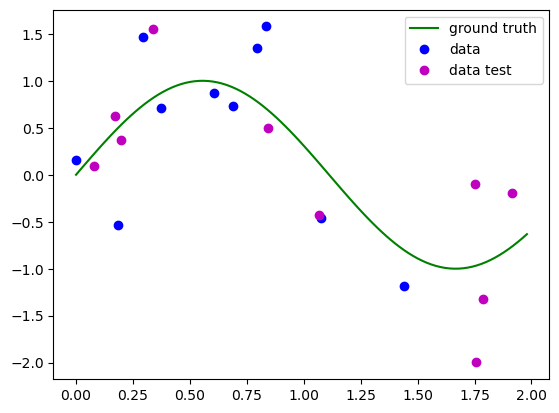

In [3]:
np.random.seed(1)      
N= 10    # nombre d'exemples
nu= 0.45 # frequence du sinus
ORDRE_MAX = 10     # ordre maximum du polynome
NOISE_EFFECT = 0.50

#La vérité 
xx = np.asarray([2*n/(10*N) for n in range(10*N)])
xx = np.reshape(xx,(10*N,1))
sin = np.sin(2*np.pi*nu*xx)
plt.plot(xx,sin,'g', label="ground truth")

#Données disponibles
x_train = np.random.random((N,1))*2 # => uniformes dans [0,2]
bruit = np.random.randn(N,1)*NOISE_EFFECT
Y = np.sin(2*np.pi*nu*x_train)+bruit

#Données disponibles
x_test = np.random.random((N,1))*2 # => uniformes dans [0,2]
Y_test = np.sin(2*np.pi*nu*x_test)+bruit

# Affichage des données de train
plt.plot(x_train,Y,"bo",label="data")
plt.plot(x_test,Y_test,"mo",label="data test")

plt.legend()

In [4]:
# VERSION THIERRY
def features_poly(x,ordre):
    XX = x
    X = np.array(x)
    for i in range(1,ordre):
        XX = np.multiply(XX,x)
        X = np.append(X,XX,axis=1)
    return X

def polynomial_matrix(x, M):
    """
    Crée une matrice polynomiale à partir d'un vecteur d'entrée x jusqu'au degré M.

    Parameters:
    - x (array-like): Vecteur des données d'entrée.
    - M (int): Degré maximal du polynôme.

    Returns:
    - X (array): Matrice polynomiale avec les puissances successives de x jusqu'au degré M.
    """

    # Utilise la fonction numpy.vander pour créer la matrice polynomiale
    # Pour cela x doit être un tableau à une dimension
    x_flat = np.ravel(x)
    X = np.vander(x_flat, M + 1, increasing=True)

    return X

X = polynomial_matrix(x_train, ORDRE_MAX)

In [5]:
def regression(x, Y, M, weight_decay=False, Lambda=1):
    """
    Effectue une régression polynomiale de degré M sur les données d'entrée x et les valeurs cibles Y.

    Parameters:
    - x (array-like): Vecteur des données d'entrée.
    - Y (array-like): Vecteur des valeurs cibles.
    - M (int): Degré du polynôme pour la régression polynomiale.
    - weight_decay (bool, optional): Indique si la régularisation de type "weight decay" (L2) doit être appliquée.
    - Lambda (float, optional): Paramètre de régularisation pour la régularisation L2. Ignoré si weight_decay est False.

    Returns:
    - X (array): Matrice polynomiale avec les puissances successives de x jusqu'au degré M.
    - Theta (array): Vecteur des coefficients du modèle de régression.
    """

    # Création de la matrice d'identité pondérée pour la régularisation L2
    if weight_decay:
        I = np.identity(M + 1) * Lambda
    else:
        I = np.zeros((M + 1, M + 1))

    # Construction de la matrice X avec les puissances successives de x
    X =  polynomial_matrix(x, M)

    # Transposition de la matrice X
    XT = X.T

    # Calcul des coefficients Theta avec régularisation L2 (weight decay)
    Theta = np.linalg.inv(I + XT @ X) @ XT @ Y

    return X, Theta


### Test de la fonction 
m = 5
X, Theta = regression(x_train,Y,m,weight_decay=False)
Y_pred = X @ Theta #prédiction des valeurs de Y

: 

In [63]:
def get_MSE(Y, Y_pred):
    return ((Y - Y_pred).T @ (Y - Y_pred) / Y.shape[0])[0][0]

print(get_MSE(Y, Y_pred))

0.23739727502595293


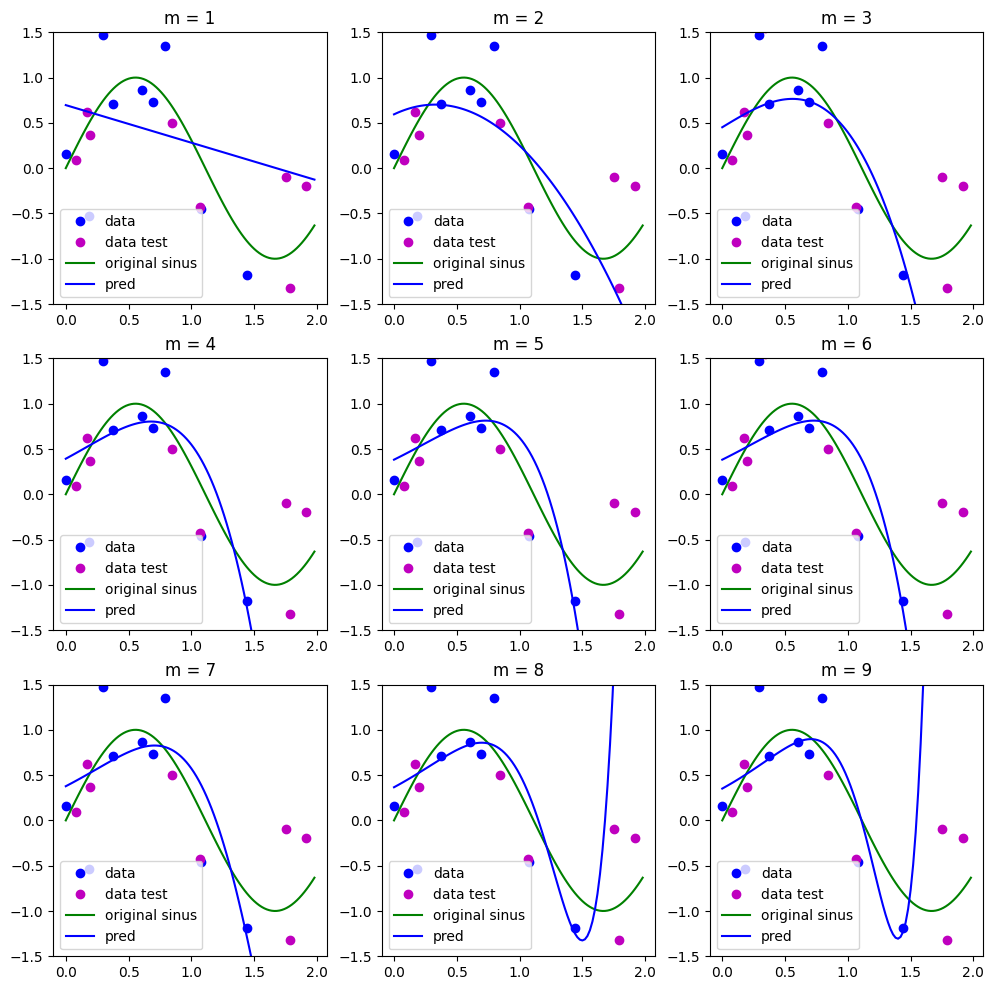

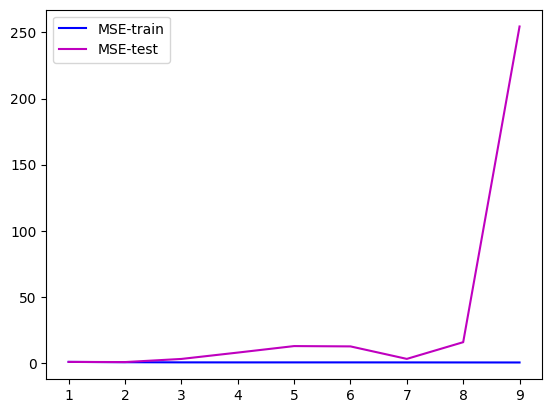

In [74]:
mse_train, mse_test = [], []
ORDRE_MAX = 10
fig, axs = plt.subplots(3,3,figsize=(12,12))
for m in range(1,ORDRE_MAX):
    X, Theta = regression(x_train,Y,m,weight_decay=True, Lambda=0.5)
    Y_pred = X @ Theta #prédiction des valeurs de Y
    mse_train.append(get_MSE(Y, Y_pred))
    
    #prédiction sur toutes les valeurs de x pour créer une courbe
    X_test =  polynomial_matrix(x_test, m)
    Y_pred_test = X_test @ Theta    
    mse_test.append(get_MSE(Y_test, Y_pred_test))

    #prédiction sur toutes les valeurs de x pour créer une courbe
    XX =  polynomial_matrix(xx, m)
    YY_pred = XX @ Theta

    plt.subplot(3,3,m)
    plt.ylim([-1.5,1.5])
    # les données d'apprentissage
    plt.plot(x_train,Y,"bo",label="data")
    # les données de test
    plt.plot(x_test,Y_test,"mo",label="data test")
    # la vrai fonction non bruitée
    plt.plot(xx,sin,'g', label="original sinus")

    plt.plot(xx,YY_pred,"b-", label="pred")
    plt.title(f"m = {m}")
    plt.legend()

plt.figure()
#plt.ylim([0,1])
plt.plot([x_train for x_train in range(1,ORDRE_MAX)],mse_train,"b-", label="MSE-train")
plt.plot([x_test for x_test in range(1,ORDRE_MAX)],mse_test,"m-", label="MSE-test")
plt.legend()


[0.7333633147322283, 0.5134306469394713, 0.38686054263765135, 0.36426624119833817, 0.37084222841803655, 0.3704543601843221, 0.3554678999847504, 0.3308122599129735, 0.30400556700693054]
[0.7354003793232077, 0.608079896428148, 2.9829354014872727, 7.791173551059915, 12.70572065608979, 12.468834519828349, 3.0182831150132765, 15.657693989156346, 254.48956966544355]


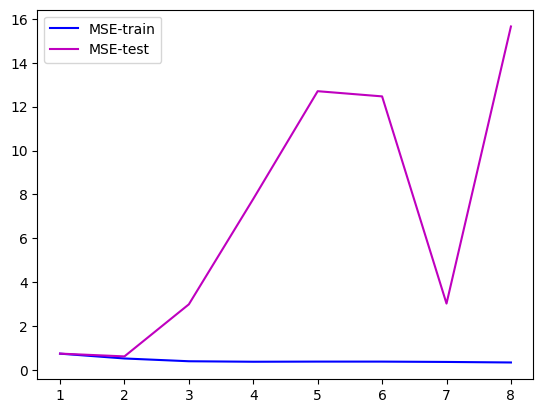

In [76]:
plt.figure()
#plt.ylim([0,1])
plt.plot([x_train for x_train in range(1,9)],mse_train[0:8],"b-", label="MSE-train")
plt.plot([x_test for x_test in range(1,9)],mse_test[0:8],"m-", label="MSE-test")
plt.legend()

print(mse_train)
print(mse_test)

## 2- Modèle polynomiale de régression et descente de gradient

In [7]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    """
    Réseau de neurones avec une couche cachée.

    Args:
        hidden_cells (int): Nombre de neurones dans la couche cachée.
        input_features (int): Nombre de caractéristiques en entrée.
    """
    def __init__(self, hidden_cells=1, input_features=1):
        super(NeuralNetwork, self).__init__()
        
        # Définition de la séquence de couches linéaires pour le réseau
        self.linear_stack = nn.Sequential(
            nn.Linear(input_features, hidden_cells),
            # Activation Sigmoid commenté pour le moment
            # nn.Sigmoid(),
            # Couche linéaire commentée pour le moment
            # nn.Linear(hidden_cells, 1),
        )

    def forward(self, x):
        """
        Méthode forward pour effectuer la propagation avant du réseau.

        Args:
            x (torch.Tensor): Entrée du réseau.

        Returns:
            torch.Tensor: Logits en sortie du réseau.
        """
        # Propagation avant à travers la séquence de couches linéaires
        logits = self.linear_stack(x)
        return logits


In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Définit la boucle d'apprentissage pour une époque complète du modèle.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader contenant les données d'entraînement.
        model (torch.nn.Module): Modèle de réseau de neurones à entraîner.
        loss_fn: Fonction de perte utilisée pour calculer la perte entre prédictions et étiquettes.
        optimizer: Optimiseur utilisé pour la mise à jour des poids du modèle.

    Returns:
        float: La perte moyenne sur l'époch.
    """
    # Taille totale du dataset
    size = len(dataloader.dataset)
    # Nombre total de batches dans le dataloader
    nb_batches = len(dataloader)
    # Initialisation de la perte totale pour l'époque à zéro
    epoch_loss = 0

    # Boucle à travers chaque batch dans le dataloader
    for batch, (data, labels) in enumerate(dataloader):
        # Prédiction et calcul de la perte
        predictions = model(data.float())
        loss = loss_fn(predictions.float(), labels.float())
        epoch_loss += loss.item()

        # Rétropropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Affichage périodique des informations d'entraînement
        if batch % 99 == 0:
            current_size = (batch + 1) * len(data)
            #print(f"Train loss: {loss.item():>7f}  [{current_size:>5d}/{size:>5d}]\n")

    # Calcul de la perte moyenne sur l'époch
    return epoch_loss / nb_batches

In [9]:
def test_loop(dataloader, model, loss_fn):
    """
    Évalue le modèle sur le jeu de validation.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader contenant les données de validation.
        model (torch.nn.Module): Modèle de réseau de neurones à évaluer.
        loss_fn: Fonction de perte utilisée pour calculer la perte entre prédictions et étiquettes.

    Returns:
        float: La perte moyenne sur le jeu de validation.
    """
    # Nombre total de batches dans le dataloader
    nb_batches = len(dataloader)
    # Initialisation de la perte totale pour le jeu de validation à zéro
    test_loss = 0

    # Utilisation de torch.no_grad() pour désactiver le suivi des gradients pendant l'évaluation
    with torch.no_grad():
        # Boucle à travers chaque batch dans le dataloader de validation
        for data, labels in dataloader:
            # Prédiction du modèle et calcul de la perte
            predictions = model(data.float())
            test_loss += loss_fn(predictions, labels).item()

    # Calcul de la perte moyenne sur le jeu de validation
    test_loss /= nb_batches
    #print(f"Average test loss: {test_loss:>8f} \n")
    
    return test_loss

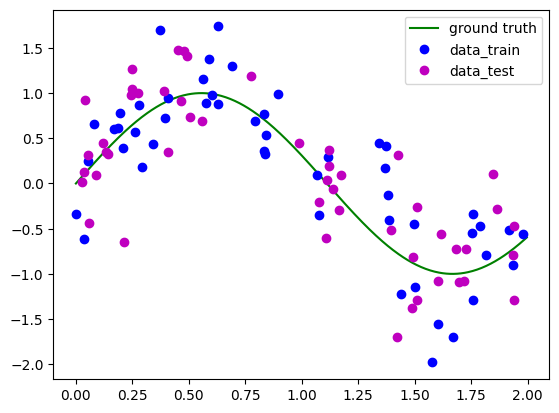

In [10]:
#Même aléatoire pour toutes les expériences
np.random.seed(1)      
torch.manual_seed(1)

N=50     # nombre d'exemples
nu=0.45 # frequence du sinus
ORDRE_MAX = 7     # ordre maximum du polynome
NOISE_EFFECT = 0.50 # amplitude du bruit 

#La vérité 
xx = np.asarray([2*n/(10*N) for n in range(10*N)])
xx = np.reshape(xx,(10*N,1))
sin = np.sin(2*np.pi*nu*xx)
plt.plot(xx,sin,'g', label="ground truth")

#Données train 
x_train = np.random.random((N,1))*2 # => uniformes dans [0,2]
bruit_train = np.random.randn(N,1)*NOISE_EFFECT
Y_train = np.sin(2*np.pi*nu*x_train)+bruit_train

#Données test
x_test = np.random.random((N,1))*2 # => uniformes dans [0,2]
bruit_test = np.random.randn(N,1)*NOISE_EFFECT
Y_test = np.sin(2*np.pi*nu*x_test)+bruit_test

# Affichage des données de train
plt.plot(x_train,Y_train,"bo",label="data_train")
plt.plot(x_test,Y_test,"mo",label="data_test")
plt.legend()

  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 3000/3000 [00:06<00:00, 439.25it/s]


Done!


100%|██████████| 3000/3000 [00:06<00:00, 440.96it/s]


Done!


100%|██████████| 3000/3000 [00:05<00:00, 501.41it/s]


Done!


100%|██████████| 3000/3000 [00:06<00:00, 456.98it/s]


Done!


100%|██████████| 3000/3000 [00:06<00:00, 484.01it/s]


Done!


100%|██████████| 3000/3000 [00:06<00:00, 478.36it/s]


Done!


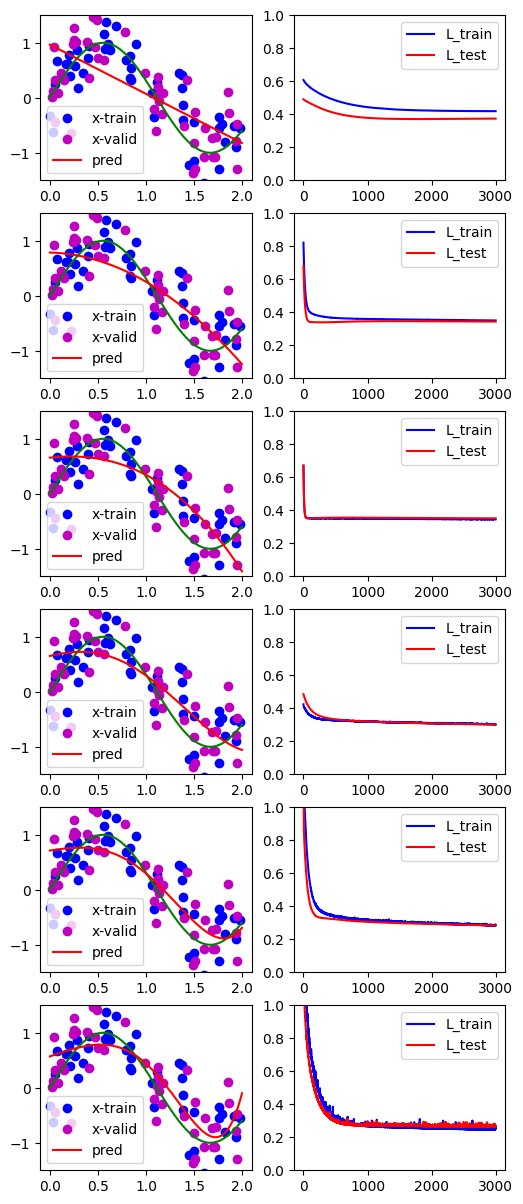

In [11]:
from torch.utils.data import DataLoader


# DEFINITION DU RESEAU
LEARNING_RATE = 1e-3 # 1e-3  1e-4
EPOCHS = 3000
WEIGHT_DECAY = 0.01  #, 0.01, 0.05, 0.1]:
BATCH_SIZE = 25
HIDDEN_CELLS = 1 # une seule cellule pour le régresseur polynomial


# pour mémoriser l'évolution de la loss
train_losses = {i: [] for i in range(1,ORDRE_MAX)}
test_losses = {i: [] for i in range(1,ORDRE_MAX)}

hauteur_plot = ORDRE_MAX-1
fig1, axs1 = plt.subplots(hauteur_plot,2,figsize=(6,15))

for ordre in range(1, ORDRE_MAX):
        ### définition des données d'appentissage 
        train_dataloader = DataLoader(list(zip(polynomial_matrix(x_train,ordre), Y_train)), 
                                      batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
        ### définition des données de test pour la validation
        test_dataloader = DataLoader(list(zip(polynomial_matrix(x_test,ordre), Y_test)), 
                                      batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
        
        # pour visualisaser la fonction de régression
        regression_dataloader = DataLoader(list(zip(polynomial_matrix(xx,ordre), sin)), 
                                          batch_size=BATCH_SIZE*N, shuffle=False, drop_last=False)
        
        ### DÉFINITION DU MODELE
        model = NeuralNetwork(hidden_cells=HIDDEN_CELLS,input_features=ordre+1)
        mse_loss = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), 
                              lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)

        # optimizer = torch.optim.AdamW(model.parameters(), 
        #                         lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
        ### BOUCLE D'APPRENTISSAGE
        for epoch in tqdm(range(EPOCHS)):
            train_loss = train_loop(train_dataloader, model, mse_loss, optimizer)
            train_losses[ordre].append(train_loss)
            # on test à chaque itération 
            test_loss = test_loop(test_dataloader, model, mse_loss)
            test_losses[ordre].append(test_loss)
        print("Done!")
        
        #calcule de la fonction de régression pour visualisation
        with torch.no_grad():
            for X, y in regression_dataloader:
                fonction_regression = model(X.float())


        # AFFICHAGE DES PARAMETRES DU MODELE DE REGRESSION
        # print(model)
        # for param in model.parameters():
        #     print(param)
            
        #################################################
        # VISUALISATION DES RESULTATS
        ##############################################################
       
        plt.subplot(hauteur_plot,2,2*(ordre-1)+1)
        #plt.title(f"Ordre : {ordre}")

        plt.ylim([-1.5,1.5])
        # les données d'apprentissage
        plt.plot(x_train,Y_train,"bo",label="x-train")
        # les données de test
        plt.plot(x_test,Y_test,"mo",label="x-valid")        
        # la vrai fonction non bruitée
        plt.plot(xx,sin,'g')
        # la fonction de prediction
        plt.plot(xx,fonction_regression,"r-", label="pred")
        plt.legend()
        
        # visu des loss train et test
        plt.subplot(hauteur_plot,2,2*ordre)
        plt.ylim([0,1.0])
        plt.plot(train_losses[ordre],"b",label="L_train")
        plt.plot(test_losses[ordre],"r",label="L_test")
        plt.legend()